In [1]:
# %pip install caffe2
# %pip install shapely
# %pip install pyyaml==6.0.1
# %pip install pycocotools>=2.0.7
# %pip install torch==2.2.1+cu121 torchvision==0.17.1+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# %pip install opencv-python
# %pip install tensorboard
# import sys, os, distutils.core
# # Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# # See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
# !git clone 'https://github.com/facebookresearch/detectron2'
# dist = distutils.core.run_setup("./detectron2/setup.py")
# !python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
# sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
import os
import json
import random
import cv2
import torch
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
from matplotlib import pyplot as plt
from torch import __version__ as torch_ver
from detectron2 import __version__ as detectron_ver
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg, CfgNode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.data.datasets import load_coco_json
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.logger import setup_logger
logger = setup_logger()

In [3]:
TORCH_VERSION = ".".join(torch_ver.split(".")[:2])
CUDA_VERSION = torch_ver.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron_ver)
print("gpu:", torch.cuda.is_available())

torch:  2.2 ; cuda:  cu121
detectron2: 0.6
gpu: True


In [8]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 1)

In [55]:
MODEL_CONFIG = "Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml"
MODEL = MODEL_CONFIG.split('/')[-1].split('.')[0]
OUTPUT_DIR = "./" + MODEL + "-50k_iter-output"
DATASET_NAME = "agar_coco_dataset"
DATASET_PATH = "./DATASET_BIG/dataset/"
ANNOTATION_FILE_PATH = "./DATASET_BIG/dataset/annotations.json"
TRAINING_LISTS_PATH = "./DATASET_BIG/training_lists/"
CATEGORIES = ["S.aureus",
              "B.subtilis",
              "P.aeruginosa",
              "E.coli",
              "C.albicans"]  # исключили классы Defect и Contamination
CATEGORIES_DICT = {0: "S.aureus",
                   1: "B.subtilis",
                   2: "P.aeruginosa",
                   3: "E.coli",
                   4: "C.albicans"}  # исключили классы Defect и Contamination

print(MODEL)
print(OUTPUT_DIR)

cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv
./cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv-50k_iter-output


In [56]:
# !unzip -o ./NOTEBOOK/DATASETS.zip -d ./

9415.jpg


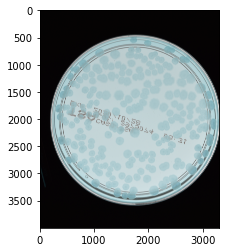

In [57]:
img = str(random.randint(1, 18000)) + ".jpg"
print(img)
im = cv2.imread(f"{DATASET_PATH}{img}")
plt.imshow(im)
plt.show()

In [58]:
yaml_config = MODEL_CONFIG if os.path.isfile(
    MODEL_CONFIG) else model_zoo.get_config_file(MODEL_CONFIG)

cfg = get_cfg()
cfg.merge_from_file(yaml_config)
cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': True, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'GeneralizedRCNN', 'WEIGHTS': 'catalog://ImageNetPretrained/FAIR/X-152-32x8d-IN5k', 'PIXEL_MEAN': [103.53, 116.28, 123.675], 'PIXEL_STD': [1.0, 1.0, 1.0], 'BACKBONE': CfgNode({'NAME': 'build_resnet_fpn_backbone', 'FREEZE_AT': 2}), 'FPN': CfgNode({'IN_FEATURES': ['res2', 'res3', 'res4', 'res5'], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32], [64], [128], [256], [512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['p2', 'p3', 'p4', 'p5', 'p6'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smoo

In [59]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_CONFIG)
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/10 17:55:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv/18131413/model_0039999_e76410.pkl ...


In [60]:
print("pred_boxes:", outputs["instances"].pred_boxes)
print("scores:", outputs["instances"].scores)
print("pred_classes:", outputs["instances"].pred_classes)

pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4)))
scores: tensor([], device='cuda:0')
pred_classes: tensor([], device='cuda:0', dtype=torch.int64)


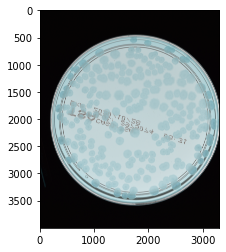

In [61]:
metric_val = Visualizer(
    im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = metric_val.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [62]:
def get_ids_by_train_list(training_list_path: str) -> list[int]:
    with open(training_list_path, 'r') as f:
        data = f.read()
    j = json.loads(data)
    str_ids = [num for num in j if num != 'annotations.json']
    ids = [int(num) for num in str_ids]
    return ids


def filter_dataset_by_ids(dataset: list[dict], ids: list[int]) -> list[dict]:
    return [ann for ann in dataset if ann['image_id'] in ids]


def filter_annotations_by_categories(dataset: list[dict], categories_dict: dict[int, str]):
    for d in dataset:
        d["annotations"] = [ann for ann in d["annotations"]
                            if ann["category_id"] in list(categories_dict.keys())]
    return dataset

In [63]:
agar_coco_full_dataset = load_coco_json(json_file=ANNOTATION_FILE_PATH,
                                        image_root=DATASET_PATH,
                                        dataset_name=DATASET_NAME)
agar_coco_full_dataset = filter_annotations_by_categories(
    agar_coco_full_dataset, CATEGORIES_DICT)

[04/10 17:55:34 d2.data.datasets.coco]: Loading ./DATASET_BIG/dataset/annotations.json takes 5.88 seconds.
[04/10 17:55:34 d2.data.datasets.coco]: Loaded 18000 images in COCO format from ./DATASET_BIG/dataset/annotations.json


In [64]:
high_res_train_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_train.txt"
low_res_train_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_train.txt"
vague_train_list_path = f"{TRAINING_LISTS_PATH}vague_train.txt"
high_res_val_list_path = f"{TRAINING_LISTS_PATH}higher_resolution_val.txt"
low_res_val_list_path = f"{TRAINING_LISTS_PATH}lower_resolution_val.txt"
vague_val_list_path = f"{TRAINING_LISTS_PATH}vague_val.txt"

In [65]:
# делим на тренировочный и тестовый датасеты с изображениями
# высокого качества, низкого качества и расплывчатые (всего 6)
for metric_name, metric_val in {"high_res_train": high_res_train_list_path,
                                  "low_res_train": low_res_train_list_path,
                                  "vague_train": vague_train_list_path,
                                  "high_res_val": high_res_val_list_path,
                                  "low_res_val": low_res_val_list_path,
                                  "vague_val": vague_val_list_path}.items():
    name = f"{DATASET_NAME}_{metric_name}"
    try:
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)
    except:
        pass
    print("Registering '{}' DatasetCatalog by path {}".format(name, metric_val))
    DatasetCatalog.register(name, lambda v=metric_val:
                            filter_dataset_by_ids(dataset=agar_coco_full_dataset,
                                                  ids=get_ids_by_train_list(v)))
    MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
    MetadataCatalog.get(name).set(image_root=DATASET_PATH)
    MetadataCatalog.get(name).set(evaluator_type='coco')
    print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
        name, len(DatasetCatalog.get(name))))
    print("Metadata of {}: {}\n".format(name, MetadataCatalog.get(name)))

Registering 'agar_coco_dataset_high_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/higher_resolution_train.txt
Successfully registered 'agar_coco_dataset_high_res_train' DatasetCatalog containing 5241 indices
Metadata of agar_coco_dataset_high_res_train: Metadata(name='agar_coco_dataset_high_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_low_res_train' DatasetCatalog by path ./DATASET_BIG/training_lists/lower_resolution_train.txt
Successfully registered 'agar_coco_dataset_low_res_train' DatasetCatalog containing 3318 indices
Metadata of agar_coco_dataset_low_res_train: Metadata(name='agar_coco_dataset_low_res_train', thing_classes=['S.aureus', 'B.subtilis', 'P.aeruginosa', 'E.coli', 'C.albicans'], image_root='./DATASET_BIG/dataset/', evaluator_type='coco')

Registering 'agar_coco_dataset_vague_train' DatasetCatalog by path ./DATASET_

In [66]:
# объединение всех валидационных датасетов в один
name = f"{DATASET_NAME}_all_val"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, metric_val))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val"))
MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_val' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_val' DatasetCatalog containing 3067 indices


namespace(name='agar_coco_dataset_all_val',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans'],
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

In [67]:
# объединение всех тренировочных датасетов в один
name = f"{DATASET_NAME}_all_train"
try:
    DatasetCatalog.remove(name)
    MetadataCatalog.remove(name)
except:
    pass
print("Registering '{}' DatasetCatalog by path {}".format(name, metric_val))
DatasetCatalog.register(name, lambda: DatasetCatalog.get(f"{DATASET_NAME}_low_res_train") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_train") + DatasetCatalog.get(f"{DATASET_NAME}_vague_train"))
MetadataCatalog.get(name).set(thing_classes=CATEGORIES)
MetadataCatalog.get(name).set(image_root=DATASET_PATH)
MetadataCatalog.get(name).set(evaluator_type='coco')
print("Successfully registered '{}' DatasetCatalog containing {} indices".format(
    name, len(DatasetCatalog.get(name))))
MetadataCatalog.get(name)

Registering 'agar_coco_dataset_all_train' DatasetCatalog by path ./DATASET_BIG/training_lists/vague_val.txt
Successfully registered 'agar_coco_dataset_all_train' DatasetCatalog containing 9202 indices


namespace(name='agar_coco_dataset_all_train',
          thing_classes=['S.aureus',
                         'B.subtilis',
                         'P.aeruginosa',
                         'E.coli',
                         'C.albicans'],
          image_root='./DATASET_BIG/dataset/',
          evaluator_type='coco')

./DATASET_BIG/dataset/14227.jpg


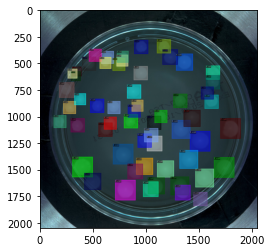

In [68]:
# To verify the dataset is in correct format,
# let's visualize the annotations of randomly selected samples in the training set
for d in random.sample(DatasetCatalog.get(f"{DATASET_NAME}_low_res_train"), 1):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1],
                            metadata=MetadataCatalog.get(
                                f"{DATASET_NAME}_low_res_train"),
                            scale=1.0)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [69]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(MODEL_CONFIG))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_high_res_train",
                      f"{DATASET_NAME}_low_res_train",
                      f"{DATASET_NAME}_vague_train")
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(MODEL_CONFIG)
cfg.OUTPUT_DIR = OUTPUT_DIR
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 50_000
cfg.SOLVER.STEPS = (10_000,)
cfg.SOLVER.BASE_LR = 0.00025
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
cfg.TEST.DETECTIONS_PER_IMAGE = 300
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False  # под вопросом
# Minimum size of the side of the image during training
cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1024)
# Maximum size of the side of the image during training
cfg.INPUT.MAX_SIZE_TRAIN = 2048
# Size of the smallest side of the image during testing. Set to zero to disable resize in testing.
cfg.INPUT.MIN_SIZE_TEST = 1024
# Maximum size of the side of the image during testing
cfg.INPUT.MAX_SIZE_TEST = 2048
# нет цели сегментировать колонии, к тому же датасет не содержит этой информации
cfg.MODEL.MASK_ON = False
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [70]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)

[04/10 17:55:46 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [71]:
print(f"Start training on {cfg.MODEL.DEVICE}")
trainer.train()

Start training on cuda
[04/10 17:55:49 d2.engine.train_loop]: Starting training from iteration 50000
[04/10 17:55:49 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


[04/10 17:55:49 d2.utils.events]:  iter: 50001       lr: N/A  max_mem: 3522M


In [72]:
print(f"Веса в директории {OUTPUT_DIR}:")
!ls {OUTPUT_DIR}/ | grep '.pth' | grep 'model'

Веса в директории ./cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv-50k_iter-output:
model_0004999.pth
model_0009999.pth
model_0014999.pth
model_0019999.pth
model_0024999.pth
model_0029999.pth
model_0034999.pth
model_0039999.pth
model_0044999.pth
model_0049999.pth
model_final.pth


In [73]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
# path to the model we just trained
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
# нет цели сегментировать колонии, к тому же датасет не содержит этой информации
cfg.MODEL.MASK_ON = False
predictor = DefaultPredictor(cfg)

[04/10 17:55:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv-50k_iter-output/model_final.pth ...


In [74]:
def build_actual_cfg(model_config: str, output_dir: str):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_config))
    cfg.DATASETS.TEST = ()
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_config)
    cfg.OUTPUT_DIR = output_dir
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.MAX_ITER = 50_000
    cfg.SOLVER.STEPS = (10_000,)
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5
    cfg.TEST.DETECTIONS_PER_IMAGE = 300
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.INPUT.MIN_SIZE_TRAIN = (1024, 1024)
    cfg.INPUT.MAX_SIZE_TRAIN = 2048
    cfg.INPUT.MIN_SIZE_TEST = 1024
    cfg.INPUT.MAX_SIZE_TEST = 2048
    cfg.MODEL.MASK_ON = False
    return cfg

def save_config(cfg: CfgNode, output_dir: str):
    config_name = "config.yaml"
    with open(os.path.join(output_dir, config_name), "w") as f:
        f.write(cfg.dump())
        print(f"Создан конфиг для модели в директории {output_dir}:", config_name)
        
def average_metrics(results) -> dict:
    """Вычисляет средние значения метрик из результатов по нескольким датасетам.

    Args:
        results (OrderedDict): Результаты, полученные от Trainer.test().

    Returns:
        dict: Словарь, где ключи - названия метрик, значения - средние значения этих метрик по трём датасетам.
    """
    metrics = {}
    counts = {}  # Отслеживание количества значений для каждой метрики

    for dataset_name, dataset_results in results.items():
        for task, task_results in dataset_results.items():
            for metric, value in task_results.items():
                if not metric in metrics:
                    metrics[metric] = 0
                    counts[metric] = 0
                if not pd.isna(value):
                    metrics[metric] += value
                    counts[metric] += 1

    # Вычисление средних значений
    for metric in metrics:
        metrics[metric] /= counts[metric]

    return metrics

def calc_metrics_and_visualize_in_tensorboard(cfg: CfgNode, output_dir: str):
    iterations = [4999, 9999, 14999, 19999, 24999,
                    29999, 34999, 39999, 44999, 49999]
    with SummaryWriter(log_dir=output_dir) as writer:
        for iter in iterations:
            weight_file_names = !ls {output_dir}/ | grep '.pth' | grep 'model' | grep {iter} | head -1
            weight_file_name = weight_file_names[0]
            print(f"[{iter} iter] Найден файл с весами {weight_file_name}")
            cfg.MODEL.WEIGHTS = os.path.join(output_dir, weight_file_name)
            predictor = DefaultPredictor(cfg)
            evaluators = [COCOEvaluator(test_ds, output_dir=output_dir, allow_cached_coco=False) for test_ds in cfg.DATASETS.TEST]
            print(f"[{iter} iter] Начато тестирование модели...")
            test_results = trainer.test(cfg=cfg, model=predictor.model, evaluators=evaluators)
            print(f"[{iter} iter] Тестирование модели завершено. Результаты: {test_results}")
            for ds_name, results in test_results.items():
                print(f"[{iter} iter] Заполнение метрик TensorBoard для датасета {ds_name}...")
                for metric_name, metric_val in results['bbox'].items():
                    tensorboard_metric_name = f"metrics/{metric_name}/{ds_name}"
                    writer.add_scalar(tensorboard_metric_name, metric_val, iter)
                    print(f"[{iter} iter] Для метрики {tensorboard_metric_name} записан результат {metric_val}")
            for metric_name, metric_val in average_metrics(test_results).items():
                tensorboard_metric_name = f"metrics/{metric_name}/full_val_dataset"
                writer.add_scalar(tensorboard_metric_name, metric_val, iter)
                print(f"[{iter} iter] Для метрики {tensorboard_metric_name} записан результат {metric_val}")

In [75]:
model_yamls = [
    # "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    # "COCO-Detection/retinanet_R_101_FPN_3x.yaml",

    # "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
    # "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml",
    # "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml",

    "Misc/mask_rcnn_R_50_FPN_3x_dconv_c3-c5.yaml",
    "Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml",
    "Misc/cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv.yaml",
]

output_dirs = [
    # "retinanet_R_50_FPN_3x-50k_iter-output",
    # "retinanet_R_101_FPN_3x-50k_iter-output",

    # "faster_rcnn_R_50_FPN_3x-50k_iter-output",
    # "faster_rcnn_R_101_FPN_3x-50k_iter-output",
    # "faster_rcnn_X_101_32x8d_FPN_3x-50k_iter-output",

    "mask_rcnn_R_50_FPN_3x_dconv_c3-c5-50k_iter-output",
    "cascade_mask_rcnn_R_50_FPN_3x-50k_iter-output",
    "cascade_mask_rcnn_X_152_32x8d_FPN_IN5k_gn_dconv-50k_iter-output",
]

In [76]:
# for yaml, out_dir in zip(model_yamls, output_dirs):
#     cfg = build_actual_cfg(yaml, out_dir)
#     cfg.MODEL.WEIGHTS = os.path.join(out_dir, "model_final.pth")
#     cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_high_res_train",
#                           f"{DATASET_NAME}_low_res_train",
#                           f"{DATASET_NAME}_vague_train")
#     cfg.DATASETS.TEST = (f"{DATASET_NAME}_high_res_val",
#                          f"{DATASET_NAME}_low_res_val",
#                          f"{DATASET_NAME}_vague_val")
#     save_config(cfg, out_dir)
#     calc_metrics_and_visualize_in_tensorboard(cfg, out_dir)

./DATASET_BIG/dataset/15411.jpg
Total colonies found: 61


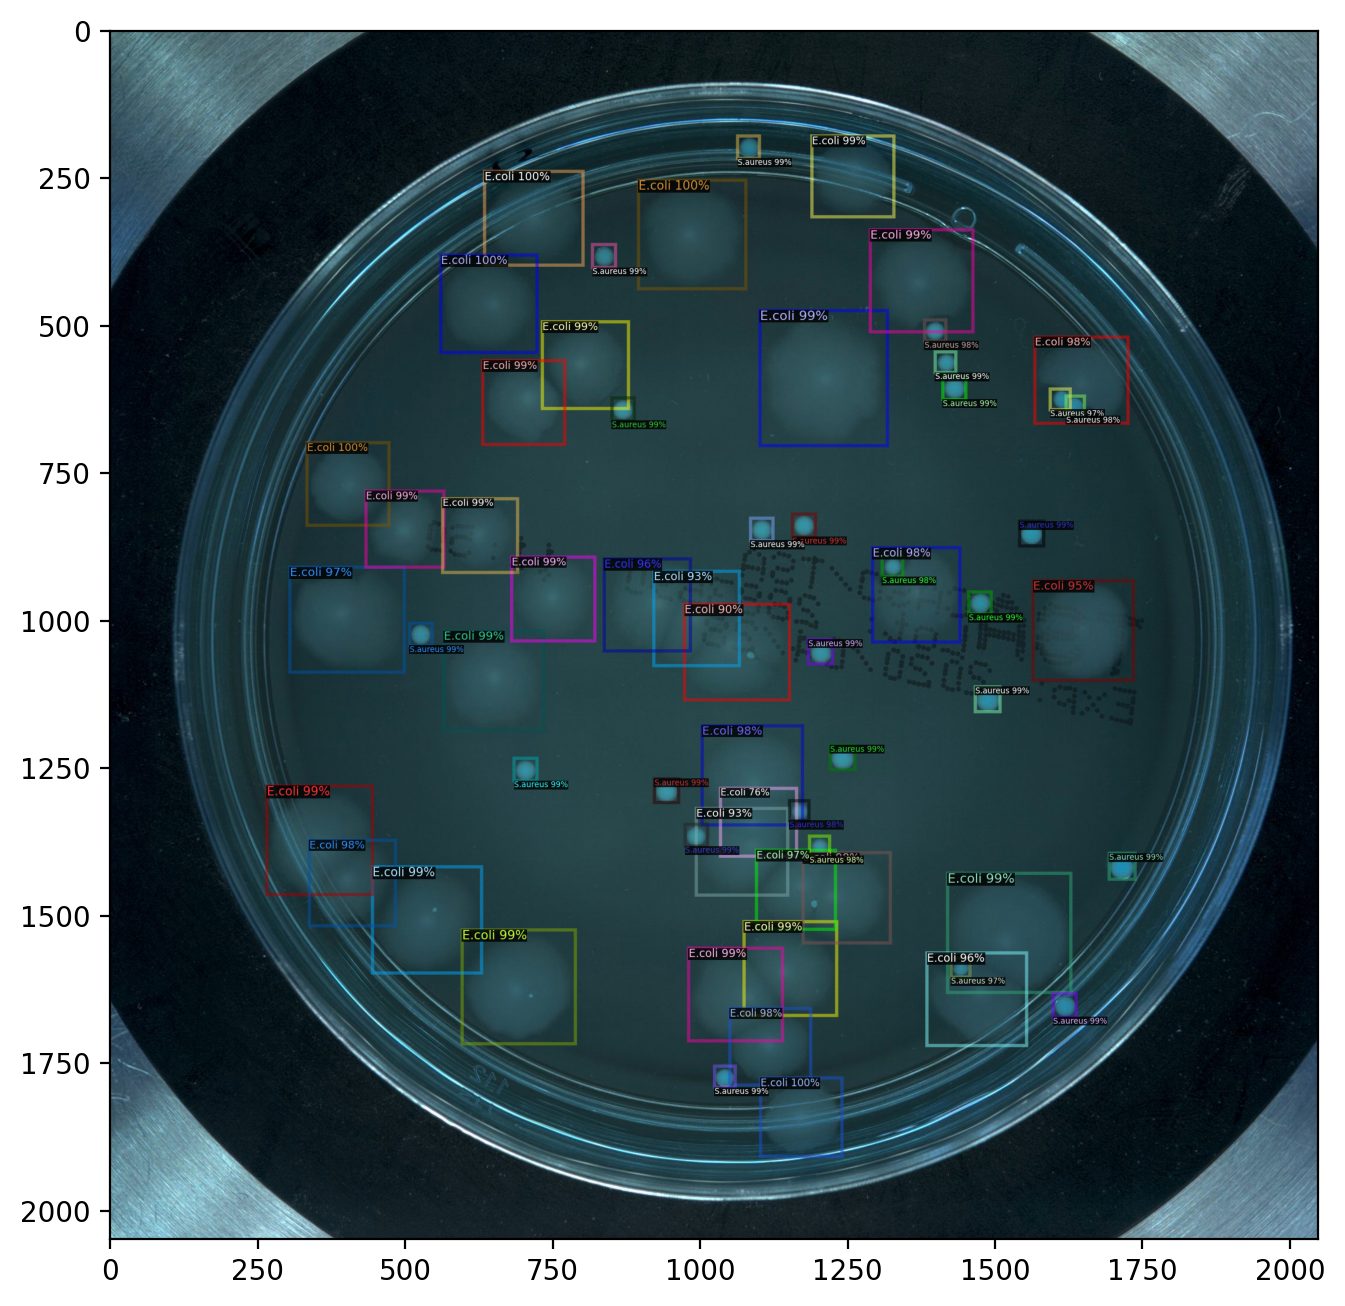

./DATASET_BIG/dataset/3483.jpg
Total colonies found: 7


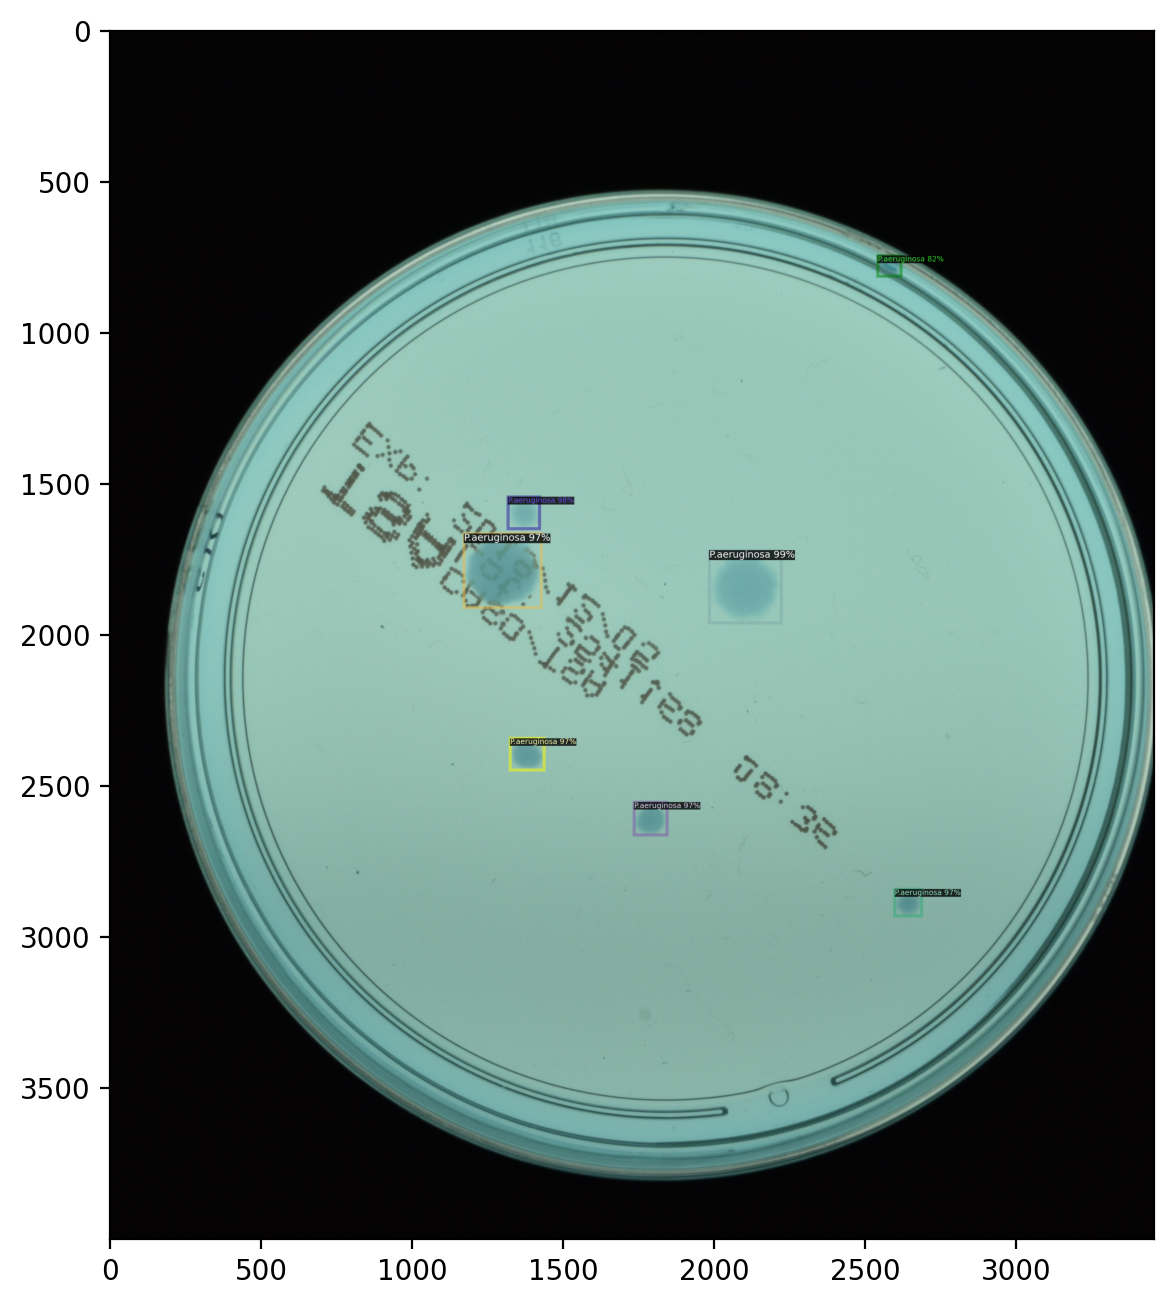

./DATASET_BIG/dataset/7971.jpg
Total colonies found: 34


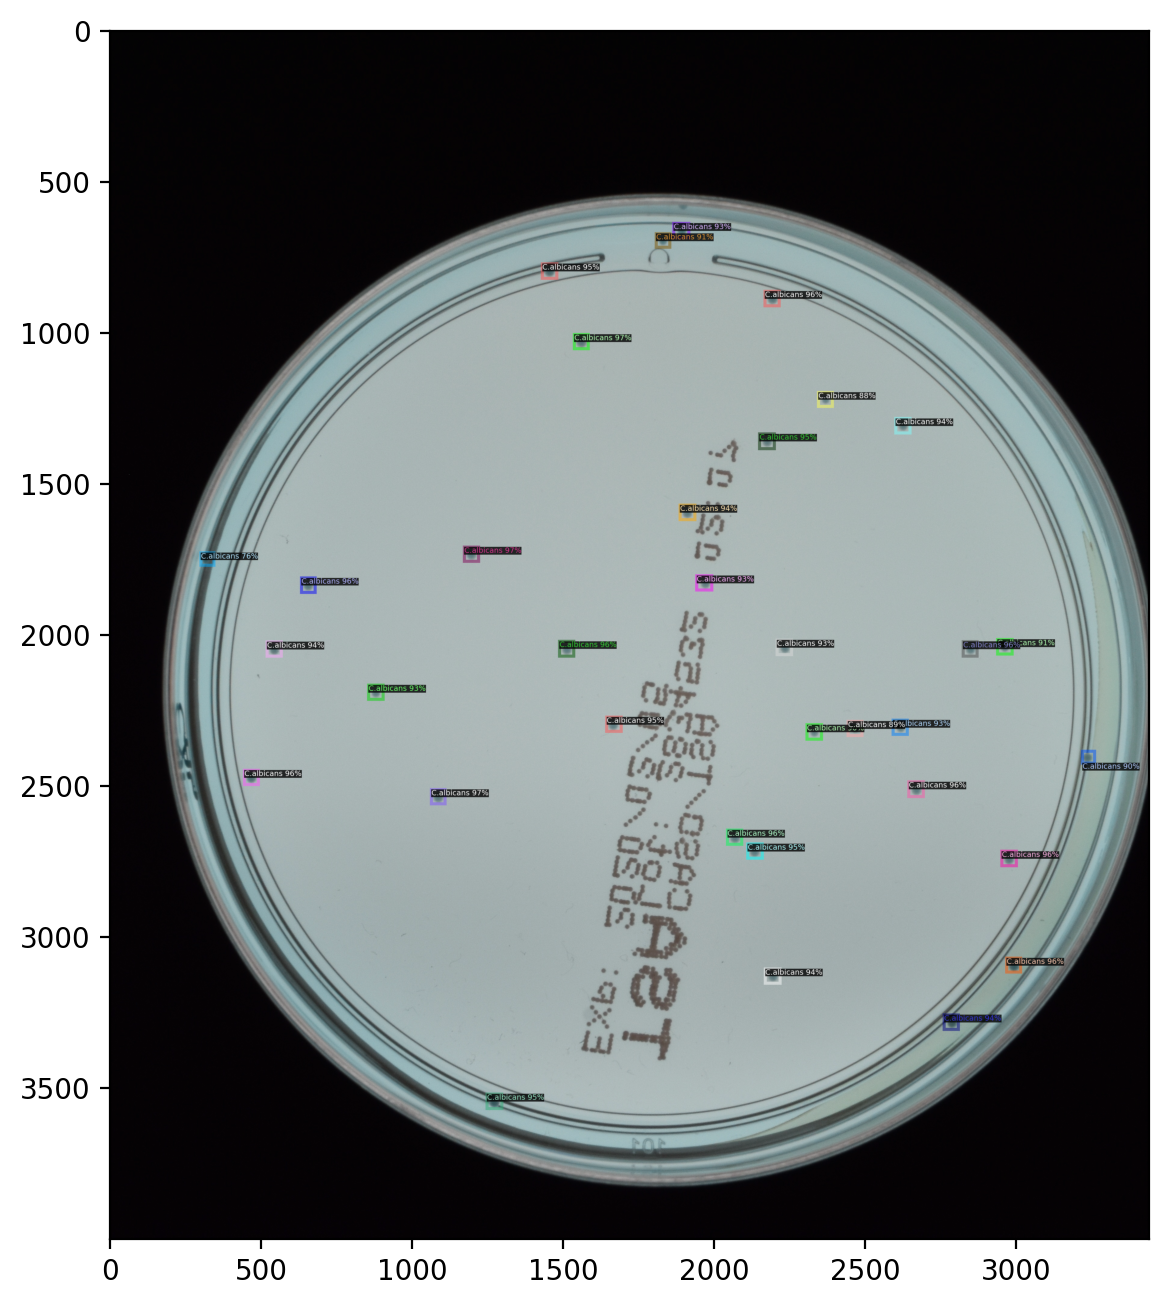

In [79]:
metadata = MetadataCatalog.get(f"{DATASET_NAME}_high_res_train")
val_datasets = DatasetCatalog.get(f"{DATASET_NAME}_low_res_val") + DatasetCatalog.get(
    f"{DATASET_NAME}_high_res_val") + DatasetCatalog.get(f"{DATASET_NAME}_vague_val")

for d in random.sample(list(val_datasets), 3):
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    print("Total colonies found:", len(outputs["instances"].pred_classes))
    metric_val = Visualizer(im[:, :, ::-1],
                              metadata=metadata,
                              scale=1.0)
    predictions = outputs["instances"].to("cpu")
    # predictions.remove('pred_masks')
    out = metric_val.draw_instance_predictions(predictions)
    plt.figure(figsize=(8, 8), dpi=200)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

[04/08 10:08:18 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |   category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:------------:|:-------------|
|  S.aureus  | 5610         | B.subtilis | 1468         | P.aeruginosa | 4053         |
|   E.coli   | 6607         | C.albicans | 3521         |              |              |
|   total    | 21259        |            |              |              |              |
[04/08 10:08:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(1024, 1024), max_size=2048, sample_style='choice')]
[04/08 10:08:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/08 10:08:18 d2.data.common]: Serializing 1106 elements to byte tensors and concatenating them all ...
[04/08 10:08:18 d2.data.common]: Serialized dataset takes 1.54 MiB


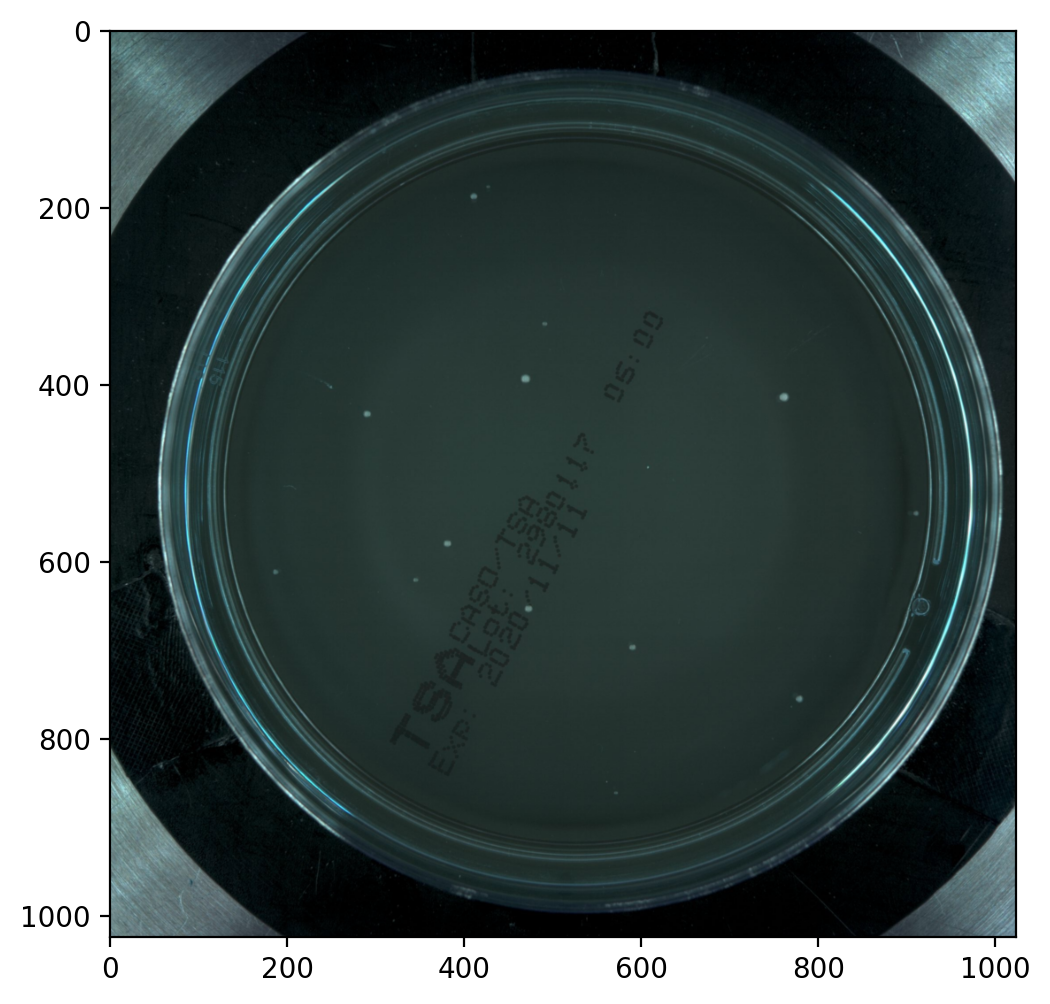

In [ ]:
# изображение после аугментаций (которое поступает на вход нейронке и эвалуатору)
test_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_low_res_val")
rnd_img = random.choice(test_loader.dataset)['image']

plt.figure(figsize=(6, 6), dpi=200)
plt.imshow(rnd_img.permute(2, 1, 0))
plt.show()

In [ ]:
# cfg.DATASETS.TEST = (f"{DATASET_NAME}_low_res_val",
#                      f"{DATASET_NAME}_high_res_val", f"{DATASET_NAME}_vague_val")
# evaluators = []
# for test_ds in cfg.DATASETS.TEST:
#     evaluator = COCOEvaluator(test_ds, output_dir=OUTPUT_DIR)
#     evaluators.append(evaluator)
# test_results = trainer.test(
#     cfg=cfg, model=predictor.model, evaluators=evaluators)
# test_results

[04/08 10:08:19 d2.evaluation.coco_evaluation]: Trying to convert 'agar_coco_dataset_low_res_val' to COCO format ...
[04/08 10:08:19 d2.data.datasets.coco]: Converting annotations of dataset 'agar_coco_dataset_low_res_val' to COCO format ...)


[04/08 10:08:19 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/08 10:08:22 d2.data.datasets.coco]: Conversion finished, #images: 1106, #annotations: 21259
[04/08 10:08:22 d2.data.datasets.coco]: Caching COCO format annotations at './mask_rcnn_R_50_FPN_3x_dconv_c3-c5-50k_iter-output/agar_coco_dataset_low_res_val_coco_format.json' ...
[04/08 10:08:22 d2.evaluation.coco_evaluation]: Trying to convert 'agar_coco_dataset_high_res_val' to COCO format ...
[04/08 10:08:22 d2.data.datasets.coco]: Converting annotations of dataset 'agar_coco_dataset_high_res_val' to COCO format ...)
[04/08 10:08:22 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/08 10:08:29 d2.data.datasets.coco]: Conversion finished, #images: 1747, #annotations: 57973
[04/08 10:08:29 d2.data.datasets.coco]: Caching COCO format annotations at './mask_rcnn_R_50_FPN_3x_dconv_c3-c5-50k_iter-output/agar_coco_dataset_high_res_val_coco_format.json' ...
[04/08 10:08:31 d2.evaluation.coco_eva

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(test_results)

agar_coco_dataset_low_res_val  \
bbox  {'AP': 60.96818506480493, 'AP50': 89.780473877...   

                         agar_coco_dataset_high_res_val  \
bbox  {'AP': 52.18185802278633, 'AP50': 78.687803508...   

                            agar_coco_dataset_vague_val  
bbox  {'AP': 56.92806218997426, 'AP50': 89.927833143...

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_high_res_val'])

bbox
AP               52.181858
AP-B.subtilis    60.182362
AP-C.albicans    38.357323
AP-E.coli        57.770074
AP-P.aeruginosa  54.180818
AP-S.aureus      50.418712
AP50             78.687804
AP75             60.630370
APl              59.711492
APm              33.176707
APs               8.295898

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_low_res_val'])

bbox
AP               60.968185
AP-B.subtilis    58.467189
AP-C.albicans    55.121028
AP-E.coli        72.519910
AP-P.aeruginosa  64.095245
AP-S.aureus      54.637554
AP50             89.780474
AP75             73.076907
APl              69.833805
APm              54.720778
APs              15.395760

In [ ]:
pd.DataFrame(test_results['agar_coco_dataset_vague_val'])

bbox
AP               56.928062
AP-B.subtilis          NaN
AP-C.albicans          NaN
AP-E.coli        68.782366
AP-P.aeruginosa  54.891832
AP-S.aureus      47.109989
AP50             89.927833
AP75             63.785279
APl              62.926748
APm              39.508696
APs              12.397587